In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import scipy.io as sio
slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
from nets import txtbox_300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from nets import txtbox_300, textbox_common, np_methods
from processing import txt_preprocessing
from processing import visualization

In [29]:
isess = tf.InteractiveSession()

In [30]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.

image_pre, labels_pre, bboxes_pre, bbox_img = txt_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=txt_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'net' in locals() else None
net = txtbox_300.TextboxNet()
#anchors = net.anchors(net_shape)
with slim.arg_scope(net.arg_scope(data_format=data_format)):
    localisations, predictions,  _ = net.net(image_4d, is_training=False, reuse=True)
    #localisations, predictions = net.bboxes_encode(bboxes_pre, anchors, 3,match_threshold = 0.5)
    for i in range(len(predictions)):
        predictions[i] = tf.nn.softmax(predictions[i])
        


In [32]:
# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-1337.meta'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(ckpt_filename)
saver.restore(isess, '../checkpoints/model.ckpt-14499')

# SSD default anchor boxes.
anchors = net.anchors(net_shape)

In [68]:
# Main image processing routine.
def process_image(img, select_threshold=0.99, nms_threshold=.1, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d,predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

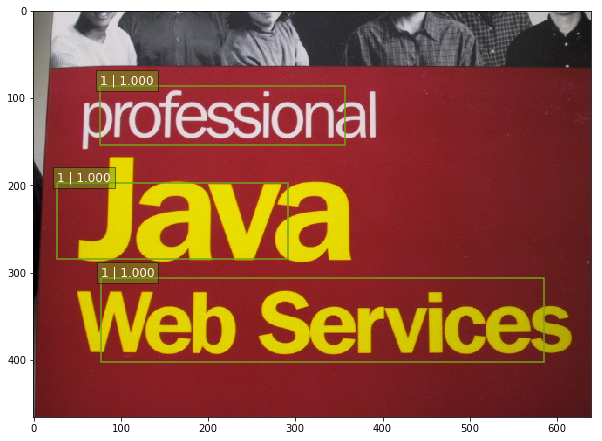

In [73]:
img = mpimg.imread('../data/ICDAR2013/ICDAR-Training-Images/118.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [52]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions[i][:,:,:,:,:,1:] > 0.99)].shape

NameError: name 'rlocalisations' is not defined

In [50]:
#rpredictions.shape
loss = isess.run(tf.nn.softmax(tf.constant([[0.52,0.47],[-0.52,-0.47]])))
logit_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = tf.constant([[0.52,0.47],[-0.52,-0.47]]),
                                                         labels =tf.constant([0,1]) )
print isess.run([logit_loss])
print loss
print isess.run(tf.reduce_mean(logit_loss))

[array([ 0.66845965,  0.66845965], dtype=float32)]
[[ 0.51249737  0.48750257]
 [ 0.48750257  0.51249737]]
0.66846


In [341]:
l1 = tf.losses.compute_weighted_loss(tf.constant([5.,1.,3.]), tf.constant([1.0,1.0,1.0]))

In [45]:
isess.run(l1)

3.0